# Dataset Preparation

- Input: Original images, each having their own different ROIs and spacing

    - FDG-PET (dicom), pCT (dicom), RTstruct (dicom)
    - HX4-PET(dicom), ldCT(dicom)
    - HX4-PET-reg(mhd/raw), ldCT-reg(mhd/raw)
    - Aorta mask drawn on ldCT, registered to pCT (.mat)

- Output: Cropped images with same ROIs (except for HX4-PET and ldCT), and resampled to common spacing

    - All images as NRRD files


Steps:
   1. Read all images to sitk (including SUV conversion for PETs, and RTstruct-to-mask conversion for contours)
   2. Crop each pair to common ROIs and resample to common spacing -- 
       - FDG-PET, pCT and masks 
       - HX4-PET and ldCT
       - HX4-PET-reg and ldCT-reg
   3. Further crop (2.1) and (2.3) (i.e. paired images) to common ROIs, and hope that (2.2) need no cropping

Anomalous cases:

1. Patient N046 doesn't have a body mask 

In [1]:
import warnings
import glob
import math
from os.path import join
from datetime import time, datetime

import numpy as np
import scipy.ndimage
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from scipy.interpolate import RegularGridInterpolator
from skimage.draw import polygon
import SimpleITK as sitk
import pydicom as pdcm
from pydicom.tag import Tag

from viz_utils import NdimageVisualizer

In [2]:
visualizer = NdimageVisualizer()

## 0. Utils

In [3]:
def np2sitk(np_image, pixel_spacing, origin):
    sitk_image = sitk.GetImageFromArray(np_image)
    sitk_image.SetSpacing(pixel_spacing)
    sitk_image.SetOrigin(origin)
    return sitk_image

### 0.1. SUV calculation utils


In [4]:
def get_physical_values_pt(slices, patient_weight, dtype=np.float32):
    s = slices[0]
    units = s.Units
    if units == 'BQML':
        acquisition_datetime = datetime.strptime(
            s[Tag(0x00080022)].value + s[Tag(0x00080032)].value.split('.')[0],
            "%Y%m%d%H%M%S")
        serie_datetime = datetime.strptime(
            s[Tag(0x00080021)].value + s[Tag(0x00080031)].value.split('.')[0],
            "%Y%m%d%H%M%S")

        try:
            if (serie_datetime <= acquisition_datetime) and (
                    serie_datetime > datetime(1950, 1, 1)):
                scan_datetime = serie_datetime
            else:
                scan_datetime_value = s[Tag(0x0009100d)].value
                if isinstance(scan_datetime_value, bytes):
                    scan_datetime_str = scan_datetime_value.decode(
                        "utf-8").split('.')[0]
                elif isinstance(scan_datetime_value, str):
                    scan_datetime_str = scan_datetime_value.split('.')[0]
                else:
                    raise ValueError(
                        "The value of scandatetime is not handled")
                scan_datetime = datetime.strptime(scan_datetime_str,
                                                  "%Y%m%d%H%M%S")

            start_time_str = s.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
            start_time = time(int(start_time_str[0:2]),
                              int(start_time_str[2:4]),
                              int(start_time_str[4:6]))
            start_datetime = datetime.combine(scan_datetime.date(), start_time)
            decay_time = (scan_datetime - start_datetime).total_seconds()
        except KeyError:
            warnings.warn("Estimation of time decay for SUV"
                          " computation from average parameters")
            decay_time = 1.75 * 3600  # From Martin's code
        return get_suv_from_bqml(slices,
                                 decay_time,
                                 patient_weight,
                                 dtype=dtype)

    elif units == 'CNTS':
        return get_suv_philips(slices, dtype=dtype)
    else:
        raise ValueError('The {} units is not handled'.format(units))


def get_suv_philips(slices, dtype=np.float32):
    image = list()
    suv_scale_factor_tag = Tag(0x70531000)
    for s in slices:
        im = (float(s.RescaleSlope) * s.pixel_array +
              float(s.RescaleIntercept)) * float(s[suv_scale_factor_tag].value)
        image.append(im)
    return np.stack(image, axis=-1).astype(dtype)


def get_suv_from_bqml(slices, decay_time, patient_weight, dtype=np.float32):
    # Get SUV from raw PET
    image = list()
    for s in slices:
        pet = float(s.RescaleSlope) * s.pixel_array + float(s.RescaleIntercept)
        half_life = float(s.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
        total_dose = float(s.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
        decay = 2**(-decay_time / half_life)
        actual_activity = total_dose * decay

        im = pet * patient_weight * 1000 / actual_activity
        image.append(im)
    return np.stack(image, axis=-1).astype(dtype)


### 0.2. RTstruct-to-mask conversion utils

In [5]:
def get_masks(rtstruct_file,
              labels,
              image_position_patient=None,
              axial_positions=None,
              pixel_spacing=None,
              shape=None,
              dtype=np.int8):
    contours = read_structure(rtstruct_file, labels=labels)
    return get_mask_from_contour(contours, image_position_patient, axial_positions, pixel_spacing,
                                 shape, dtype=dtype)


def read_structure(rtstruct_file, labels):
    structure = pdcm.read_file(rtstruct_file)
    contours = []
    for i, roi_seq in enumerate(structure.StructureSetROISequence):
        contour = {}
        for label in labels:
            if roi_seq.ROIName == label:
                contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
                contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
                contour['name'] = roi_seq.ROIName
                assert contour['number'] == roi_seq.ROINumber
                contour['contours'] = [s.ContourData
                    for s in structure.ROIContourSequence[i].ContourSequence]
                contours.append(contour)
    return contours


def get_mask_from_contour(contours, image_position_patient, axial_positions, pixel_spacing, shape, dtype=np.uint8):
    z = np.asarray(axial_positions)
    pos_r = image_position_patient[1]
    spacing_r = pixel_spacing[1]
    pos_c = image_position_patient[0]
    spacing_c = pixel_spacing[0]

    output = {}
    for con in contours:
        mask = np.zeros(shape, dtype=dtype)
        for current in con['contours']:
            nodes = np.array(current).reshape((-1, 3))           
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            
            try:  # Try-except patch by Chinmay because caused error in one patient (N016)
                z_index = np.where((nodes[0, 2] - 0.001 < z)
                                & (z < nodes[0, 2] + 0.001))[0][0]
            except IndexError:
                continue

            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            if len(rr) > 0 and len(cc) > 0:
                if np.max(rr) > 512 or np.max(cc) > 512:
                    raise Exception("The RTSTRUCT file is compromised")
            mask[rr, cc, z_index] = 1
        output[con['name']] = mask
    return output


def get_physical_values_ct(slices, dtype=np.float32):
    image = list()
    for s in slices:
        image.append(float(s.RescaleSlope) * s.pixel_array + float(s.RescaleIntercept))
    return np.stack(image, axis=-1).astype(dtype)

### 0.3. Crop + resample utils

For cropping and resampling a single PET-CT pair 

In [6]:
def crop_and_resample_pet_ct(pet_sitk, ct_sitk, masks=None, resample_spacing=(1.0, 1.0, 3.0)):

    bbox = get_volume_intersection_bbox(pet_sitk, ct_sitk)

    pet_crop_res_sitk = resample_and_crop(pet_sitk, bbox, resample_spacing, order=3, is_mask=False)
    ct_crop_res_sitk = resample_and_crop(ct_sitk, bbox, resample_spacing, order=3, is_mask=False)

    # Masks given ?
    if masks is not None:
        masks_crop_res = {}
        for k in masks.keys():
            masks_crop_res[k] = resample_and_crop(masks[k], bbox, resample_spacing, is_mask=True)

        return pet_crop_res_sitk, ct_crop_res_sitk, masks_crop_res
    else:
        return pet_crop_res_sitk, ct_crop_res_sitk


def resample_and_crop(sitk_image, bounding_box, resampling=(1.0, 1.0, 3.0), order=3, is_mask=False):

    pixel_spacing = sitk_image.GetSpacing()
    origin = sitk_image.GetOrigin()
    np_volume = sitk.GetArrayFromImage(sitk_image)
    np_volume = np_volume.transpose(2,1,0)  # DHW to WHD
    resampling = np.asarray(resampling)

    if is_mask:
        np_volume = resample_np_binary_volume(np_volume, origin, pixel_spacing, resampling, bounding_box)
    else:
        np_volume = resample_np_volume(np_volume, origin, pixel_spacing, resampling, bounding_box, order=order)

    origin = np.asarray([bounding_box[0], bounding_box[1], bounding_box[2]])
    sitk_image = sitk.GetImageFromArray(np_volume.transpose(2,1,0))
    sitk_image.SetSpacing(resampling)
    sitk_image.SetOrigin(origin)
    return sitk_image

def resample_np_volume(np_volume,
                       origin,
                       current_pixel_spacing,
                       resampling_px_spacing,
                       bounding_box,
                       order=3):

    zooming_matrix = np.identity(3)
    zooming_matrix[0, 0] = resampling_px_spacing[0] / current_pixel_spacing[0]
    zooming_matrix[1, 1] = resampling_px_spacing[1] / current_pixel_spacing[1]
    zooming_matrix[2, 2] = resampling_px_spacing[2] / current_pixel_spacing[2]

    offset = ((bounding_box[0] - origin[0]) / current_pixel_spacing[0],
              (bounding_box[1] - origin[1]) / current_pixel_spacing[1],
              (bounding_box[2] - origin[2]) / current_pixel_spacing[2])

    output_shape = np.ceil([
        bounding_box[3] - bounding_box[0],
        bounding_box[4] - bounding_box[1],
        bounding_box[5] - bounding_box[2],
    ]) / resampling_px_spacing

    np_volume = affine_transform(np_volume,
                                 zooming_matrix,
                                 offset=offset,
                                 mode='mirror',
                                 order=order,
                                 output_shape=output_shape.astype(int))
    return np_volume


def grid_from_spacing(start, spacing, n):
    return np.asarray([start + k * spacing for k in range(n)])


def resample_np_binary_volume(np_volume, origin, current_pixel_spacing, resampling_px_spacing, bounding_box):

    x_old = grid_from_spacing(origin[0], current_pixel_spacing[0], np_volume.shape[0])
    y_old = grid_from_spacing(origin[1], current_pixel_spacing[1], np_volume.shape[1])
    z_old = grid_from_spacing(origin[2], current_pixel_spacing[2], np_volume.shape[2])

    output_shape = (np.ceil([
        bounding_box[3] - bounding_box[0],
        bounding_box[4] - bounding_box[1],
        bounding_box[5] - bounding_box[2],
    ]) / resampling_px_spacing).astype(int)

    x_new = grid_from_spacing(bounding_box[0], resampling_px_spacing[0], output_shape[0])
    y_new = grid_from_spacing(bounding_box[1], resampling_px_spacing[1], output_shape[1])
    z_new = grid_from_spacing(bounding_box[2], resampling_px_spacing[2], output_shape[2])
    interpolator = RegularGridInterpolator((x_old, y_old, z_old),
                                           np_volume,
                                           method='nearest',
                                           bounds_error=False,
                                           fill_value=0)
    x, y, z = np.meshgrid(x_new, y_new, z_new, indexing='ij')
    pts = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))

    return interpolator(pts).reshape(output_shape)

Cropping, between two PET-CT pairs

In [7]:
def crop_pet_ct_pairs_to_common_roi(pet_sitk_1, ct_sitk_1,
                                    pet_sitk_2, ct_sitk_2,
                                    masks=None
                                    ):

    bbox = get_volume_intersection_bbox(pet_sitk_1, pet_sitk_2)

    pet_sitk_1_crop = crop_sitk(pet_sitk_1, bbox)
    ct_sitk_1_crop = crop_sitk(ct_sitk_1, bbox)
    pet_sitk_2_crop = crop_sitk(pet_sitk_2, bbox)
    ct_sitk_2_crop = crop_sitk(ct_sitk_2, bbox)

    if masks is None:
        return pet_sitk_1_crop, ct_sitk_1_crop, pet_sitk_2_crop, ct_sitk_2_crop
    else:
        masks_crop = {}
        for k in masks.keys():
            masks_crop[k] = crop_sitk(masks[k], bbox)
        return pet_sitk_1_crop, ct_sitk_1_crop, pet_sitk_2_crop, ct_sitk_2_crop, masks_crop


def crop_sitk(sitk_image, bbox):
    # Get WHD indices from physcial bbox points
    x1, y1, z1 = sitk_image.TransformPhysicalPointToIndex((bbox[0], bbox[1], bbox[2]))
    x2, y2, z2 = sitk_image.TransformPhysicalPointToIndex((bbox[3], bbox[4], bbox[5]))

    # To numpy, crop
    np_image = sitk.GetArrayFromImage(sitk_image)
    np_image = np_image.transpose(2,1,0)  # DHW to WHD
    np_image_crop = np_image[x1:x2, y1:y2, z1:z2]

    # Back to sitk, update metadata
    np_image_crop = np_image_crop.transpose(2,1,0)  # WHD to DHW
    spacing = sitk_image.GetSpacing()
    origin = (bbox[0], bbox[1], bbox[2])
    sitk_image_crop = np2sitk(np_image_crop, spacing, origin)
    return sitk_image_crop


def get_volume_intersection_bbox(sitk_image_1, sitk_image_2):
    origin_1, origin_2 = sitk_image_1.GetOrigin(), sitk_image_2.GetOrigin()
    spacing_1, spacing_2 = sitk_image_1.GetSpacing(), sitk_image_2.GetSpacing()
    width_1, width_2 = sitk_image_1.GetWidth(), sitk_image_2.GetWidth()
    height_1, height_2 = sitk_image_1.GetHeight(), sitk_image_2.GetHeight()
    depth_1, depth_2 = sitk_image_1.GetDepth(), sitk_image_2.GetDepth()

    x_max_phy_pos_1, x_max_phy_pos_2 = origin_1[0] + spacing_1[0]*width_1, origin_2[0] + spacing_2[0]*width_2
    y_max_phy_pos_1, y_max_phy_pos_2 = origin_1[1] + spacing_1[1]*height_1, origin_2[1] + spacing_2[1]*height_2
    z_max_phy_pos_1, z_max_phy_pos_2 = origin_1[2] + spacing_1[2]*depth_1, origin_2[2] + spacing_2[2]*depth_2

    x_min_crop_phy_pos, x_max_crop_phy_pos = max(origin_1[0], origin_2[0]), min(x_max_phy_pos_1, x_max_phy_pos_2)
    y_min_crop_phy_pos, y_max_crop_phy_pos = max(origin_1[1], origin_2[1]), min(y_max_phy_pos_1, y_max_phy_pos_2)
    z_min_crop_phy_pos, z_max_crop_phy_pos = max(origin_1[2], origin_2[2]), min(z_max_phy_pos_1, z_max_phy_pos_2)

    bbox = np.array([x_min_crop_phy_pos, y_min_crop_phy_pos, z_min_crop_phy_pos,
                     x_max_crop_phy_pos, y_max_crop_phy_pos, z_max_crop_phy_pos])
    return bbox

### 0.4. Readers

In [8]:
def read_pet_dicoms_to_sitk(dicom_series_dir, patient_id):
    # Read slices
    dicom_filepaths = sorted(glob.glob(f"{dicom_series_dir}/*"))
    if patient_id == 'N010':
        dicom_filepaths = dicom_filepaths[1:] # Ignore the 1st .dcm file (not a slice)
    pet_slices = [pdcm.read_file(dcm) for dcm in dicom_filepaths]
    pet_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Convert to numpy array of SUV values
    patient_weight = float(pet_slices[0].PatientWeight)
    pet_np = get_physical_values_pt(pet_slices, patient_weight, dtype=np.float32)
    pet_np = pet_np.transpose(2,0,1) # HWD to DHW

    # Convert to sitk
    slice_spacing = pet_slices[1].ImagePositionPatient[2] - pet_slices[0].ImagePositionPatient[2]
    pixel_spacing = np.asarray([pet_slices[0].PixelSpacing[0], pet_slices[0].PixelSpacing[1], slice_spacing])
    image_position_patient = [float(k) for k in pet_slices[0].ImagePositionPatient]
    pet_sitk = np2sitk(pet_np, pixel_spacing, image_position_patient)
    return pet_sitk


def read_ct_dicoms_to_sitk(dicom_series_dir, patient_id, rtstruct_filepath=None, rtstruct_roi_info=None):
    # Read slices
    dicom_filepaths = sorted(glob.glob(f"{dicom_series_dir}/*"))
    ct_slices = [pdcm.read_file(dcm) for dcm in dicom_filepaths]
    ct_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Convert to numpy array
    ct_np = get_physical_values_ct(ct_slices, dtype=np.float32)  # HWD

    slice_spacing = ct_slices[1].ImagePositionPatient[2] - ct_slices[0].ImagePositionPatient[2]
    pixel_spacing = np.asarray([ct_slices[0].PixelSpacing[0], ct_slices[0].PixelSpacing[1], slice_spacing])
    image_position_patient = [float(k) for k in ct_slices[0].ImagePositionPatient]

    # RTstruct given ?
    if rtstruct_filepath is None:
        # Convert CT to sitk and return
        ct_np = ct_np.transpose(2,0,1) # HWD to DHW
        ct_sitk = np2sitk(ct_np, pixel_spacing, image_position_patient)
        return ct_sitk

    else:
        # Convert RTstruct to masks (binary numpy arrays)
        gtv_roi_name = rtstruct_roi_info[patient_id]['gtv-roi-name']
        body_roi_name = rtstruct_roi_info[patient_id]['body-roi-name']
        
        axial_positions = np.asarray([k.ImagePositionPatient[2] for k in ct_slices])
        masks = get_masks(rtstruct_filepath,
                          labels=[gtv_roi_name, body_roi_name],
                          image_position_patient=image_position_patient,
                          axial_positions=axial_positions,
                          pixel_spacing=pixel_spacing,
                          shape=ct_np.shape,
                          dtype=np.int8)

        # Convert masks to sitk
        for k in masks.keys():
            masks[k] = masks[k].transpose(2,0,1)  # HWD to DHW
            masks[k] = np2sitk(masks[k], pixel_spacing, image_position_patient)

        # Convert CT to sitk
        ct_np = ct_np.transpose(2,0,1)  # HWD to DHW
        ct_sitk = np2sitk(ct_np, pixel_spacing, image_position_patient)
        return ct_sitk, masks

In [9]:
# DATA_ROOT_DIR = "/home/chinmay/Datasets/HX4-PET-Translation/Original"
DATA_ROOT_DIR = "/workspace/data/Chinmay/Datasets/HX4-PET-Translation/Original"
SAMPLE_PATIENT = "N010"
SAMPLE_RTSTRUCT_ROI_INFO = {'N010': 
                               {'gtv-roi-name': 'GTVp1',
                                'body-roi-name': 'BODY'}
                            }

## 1. Read images to sitk

In [10]:
# FDG-PET
dicom_series_dir = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/PT"
fdg_pet_sitk = read_pet_dicoms_to_sitk(dicom_series_dir, SAMPLE_PATIENT)

# pCT
dicom_series_dir = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/CT"
rtstruct_filepath = glob.glob(f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/FDG/RTSTRUCT/*")[0]
pct_sitk, masks = read_ct_dicoms_to_sitk(dicom_series_dir, SAMPLE_PATIENT, rtstruct_filepath, SAMPLE_RTSTRUCT_ROI_INFO)

# HX4-PET
dicom_series_dir = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/HX4/PT"
hx4_pet_sitk = read_pet_dicoms_to_sitk(dicom_series_dir, SAMPLE_PATIENT)

# ldCT
dicom_series_dir = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/HX4/CT"
ldct_sitk = read_ct_dicoms_to_sitk(dicom_series_dir, SAMPLE_PATIENT)

# HX4-PET-reg
mhd_filepath = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/reg_HX4_to_FDG/image_transformed/result.mhd"
hx4_pet_reg_sitk = sitk.ReadImage(mhd_filepath, sitk.sitkFloat32)

# ldCT-reg
mhd_filepath = f"{DATA_ROOT_DIR}/{SAMPLE_PATIENT}/reg_HX4_to_FDG/image_registered/result.1.mhd"
ldct_reg_sitk = sitk.ReadImage(mhd_filepath, sitk.sitkFloat32)


In [11]:
# ############################ For Slicer visalization of intermediate results ########
# sitk.WriteImage(fdg_pet_sitk, "./fdg_pet_crop1.nrrd", useCompression=True) 
# sitk.WriteImage(pct_sitk, "./pct_crop1.nrrd", useCompression=True)
# sitk.WriteImage(masks['BODY'], "./pct_body_full.nrrd", useCompression=True)
# sitk.WriteImage(masks['GTVp1'], "./pct_gtv_full.nrrd", useCompression=True)

## 2. Crop and resample to common ROIs and spacing

In [11]:
RESAMPLE_SPACING = (1.0, 1.0, 3.0)

### 2.1. FDG-PET, pCT and masks

In [12]:
fdg_pet_sitk, pct_sitk, masks = crop_and_resample_pet_ct(fdg_pet_sitk, pct_sitk, masks, resample_spacing=RESAMPLE_SPACING)

print(fdg_pet_sitk.GetOrigin(), pct_sitk.GetOrigin())
print(fdg_pet_sitk.GetSpacing(), pct_sitk.GetSpacing())

(-249.51171875, -428.51171875, -671.0) (-249.51171875, -428.51171875, -671.0)
(1.0, 1.0, 3.0) (1.0, 1.0, 3.0)


(500, 500, 84) (500, 500, 84)


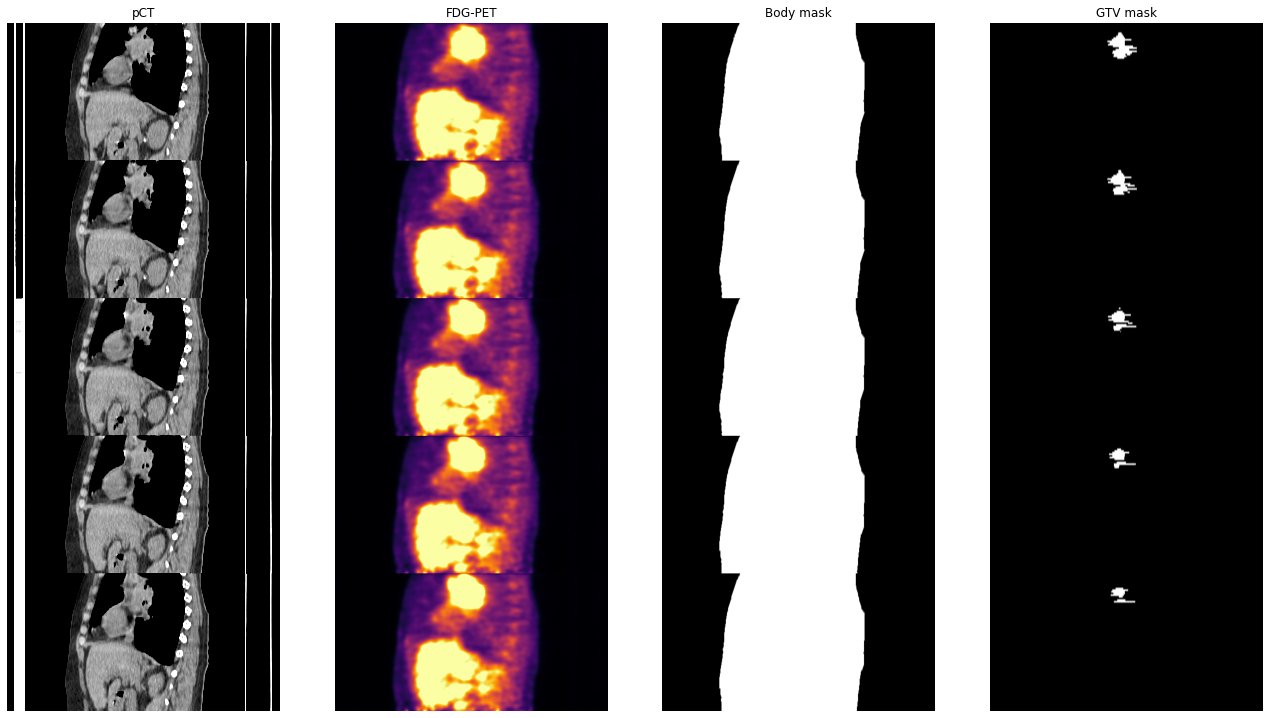

In [13]:
# Visualize
fdg_pet_np = sitk.GetArrayFromImage(fdg_pet_sitk).transpose(2,1,0)
pct_np = sitk.GetArrayFromImage(pct_sitk).transpose(2,1,0)
body_mask_np = sitk.GetArrayFromImage(masks['BODY']).transpose(2,1,0)
gtv_mask_np = sitk.GetArrayFromImage(masks['GTVp1']).transpose(2,1,0)

print(fdg_pet_np.shape, pct_np.shape)

visualizer.set_spacing(RESAMPLE_SPACING)
visualizer.multi_image_strips([pct_np, fdg_pet_np, body_mask_np, gtv_mask_np], 
                              image_types=['CT', 'PET', 'labelmap', 'labelmap'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['pCT', 'FDG-PET', 'Body mask', 'GTV mask'])

In [14]:
# ############################ For Slicer visalization of intermediate results ########
# sitk.WriteImage(fdg_pet_sitk, "./fdg_pet_crop1.nrrd", useCompression=True) 
# sitk.WriteImage(pct_sitk, "./pct_crop1.nrrd", useCompression=True)
# sitk.WriteImage(masks['BODY'], "./pct_body_crop1.nrrd", useCompression=True)
# sitk.WriteImage(masks['GTVp1'], "./pct_gtv_crop1.nrrd", useCompression=True)


### 2.2. HX4-PET and ldCT

In [14]:
hx4_pet_sitk, ldct_sitk = crop_and_resample_pet_ct(hx4_pet_sitk, ldct_sitk, resample_spacing=RESAMPLE_SPACING)

print(hx4_pet_sitk.GetOrigin(), ldct_sitk.GetOrigin())
print(hx4_pet_sitk.GetSpacing(), ldct_sitk.GetSpacing())

(-286.585938, -216.585938, 365.600006) (-286.585938, -216.585938, 365.600006)
(1.0, 1.0, 3.0) (1.0, 1.0, 3.0)


(576, 576, 60) (576, 576, 60)


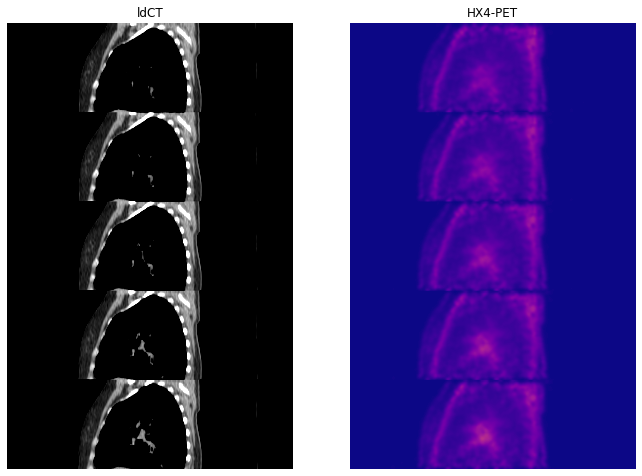

In [15]:
# Visualize
hx4_pet_np = sitk.GetArrayFromImage(hx4_pet_sitk).transpose(2,1,0)
ldct_np = sitk.GetArrayFromImage(ldct_sitk).transpose(2,1,0)

print(hx4_pet_np.shape, ldct_np.shape)

visualizer.set_spacing(RESAMPLE_SPACING)
visualizer.multi_image_strips([ldct_np, hx4_pet_np], 
                              image_types=['CT', 'PET'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['ldCT', 'HX4-PET'])

### 2.3. HX4-PET-reg and ldCT-reg

In [16]:
hx4_pet_reg_sitk, ldct_reg_sitk = crop_and_resample_pet_ct(hx4_pet_reg_sitk, ldct_reg_sitk, resample_spacing=RESAMPLE_SPACING)

print(hx4_pet_reg_sitk.GetOrigin(), ldct_reg_sitk.GetOrigin())
print(hx4_pet_reg_sitk.GetSpacing(), ldct_reg_sitk.GetSpacing())

(-249.512, -428.512, -538.977) (-249.512, -428.512, -538.977)
(1.0, 1.0, 3.0) (1.0, 1.0, 3.0)


(500, 500, 60) (500, 500, 60)


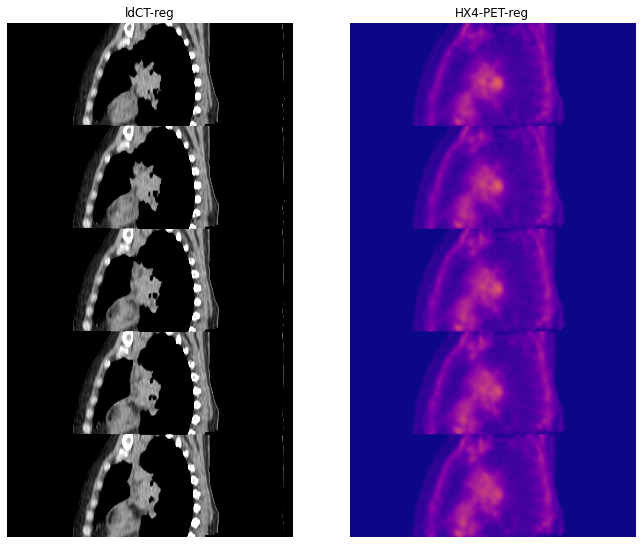

In [17]:
# Visualize
hx4_pet_reg_np = sitk.GetArrayFromImage(hx4_pet_reg_sitk).transpose(2,1,0)
ldct_reg_np = sitk.GetArrayFromImage(ldct_reg_sitk).transpose(2,1,0)

print(hx4_pet_reg_np.shape, ldct_reg_np.shape)

visualizer.set_spacing(RESAMPLE_SPACING)
visualizer.multi_image_strips([ldct_reg_np, hx4_pet_reg_np], 
                              image_types=['CT', 'PET'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['ldCT-reg', 'HX4-PET-reg'])

In [ ]:
############################ For Slicer visualization of intermediate results ########
sitk.WriteImage(fdg_pet_sitk, "./fdg_pet_crop1.nrrd", useCompression=True) 
sitk.WriteImage(pct_sitk, "./pct_crop1.nrrd", useCompression=True)
sitk.WriteImage(masks['BODY'], "./pct_body_crop1.nrrd", useCompression=True)
sitk.WriteImage(masks['GTVp1'], "./pct_gtv_crop1.nrrd", useCompression=True)
sitk.WriteImage(hx4_pet_reg_sitk, "./hx4_pet_reg_crop1.nrrd", useCompression=True)


## 3. FDG-PET, pCT, masks, HX4-PET-reg and ldCT-reg

In [18]:
fdg_pet_sitk, pct_sitk, hx4_pet_reg_sitk, ldct_reg_sitk, masks = crop_pet_ct_pairs_to_common_roi(
                                                                                                fdg_pet_sitk, 
                                                                                                pct_sitk, 
                                                                                                hx4_pet_reg_sitk, 
                                                                                                ldct_reg_sitk, 
                                                                                                masks=masks
                                                                                                )

(500, 500, 40) (500, 500, 40)
(500, 500, 40) (500, 500, 40)
(500, 500, 40) (500, 500, 40)


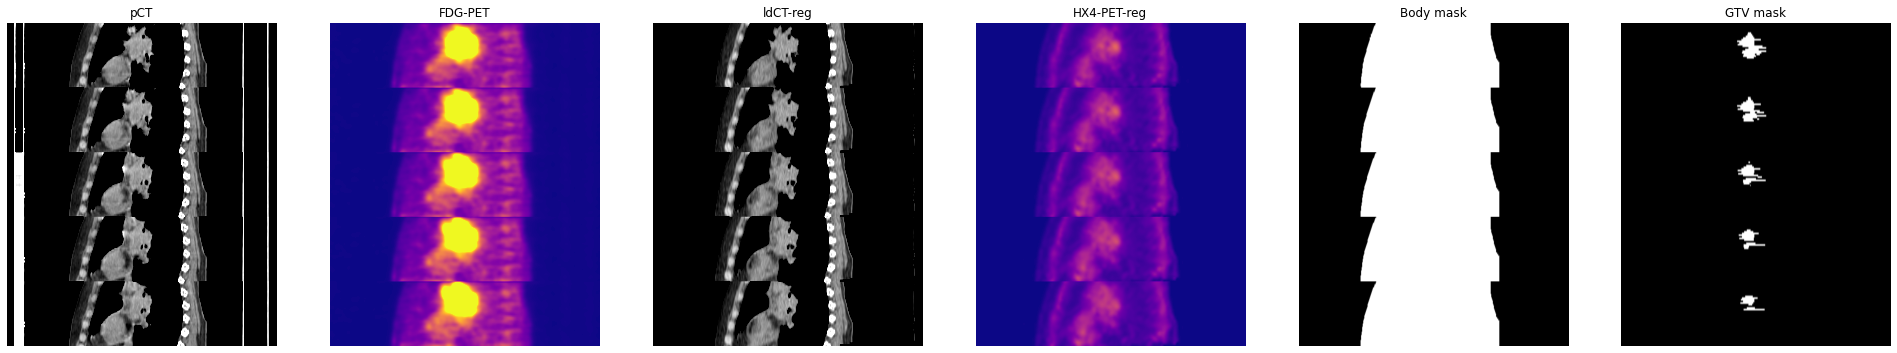

In [18]:
# Visualize
fdg_pet_np = sitk.GetArrayFromImage(fdg_pet_sitk).transpose(2,1,0)
pct_np = sitk.GetArrayFromImage(pct_sitk).transpose(2,1,0)
hx4_pet_reg_np = sitk.GetArrayFromImage(hx4_pet_reg_sitk).transpose(2,1,0)
ldct_reg_np = sitk.GetArrayFromImage(ldct_reg_sitk).transpose(2,1,0)
body_mask_np = sitk.GetArrayFromImage(masks['BODY']).transpose(2,1,0)
gtv_mask_np = sitk.GetArrayFromImage(masks['GTVp1']).transpose(2,1,0)

print(fdg_pet_np.shape, pct_np.shape)
print(hx4_pet_reg_np.shape, ldct_reg_np.shape)
print(body_mask_np.shape, gtv_mask_np.shape)

visualizer.set_spacing(RESAMPLE_SPACING)
visualizer.multi_image_strips([pct_np, fdg_pet_np, ldct_reg_np, hx4_pet_reg_np, body_mask_np, gtv_mask_np], 
                              image_types=['CT', 'PET', 'CT', 'PET', 'labelmap', 'labelmap'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['pCT', 'FDG-PET', 'ldCT-reg', 'HX4-PET-reg', 'Body mask', 'GTV mask'])

## Extras: Applying body mask (here, only to pCT) 

In [22]:
pct_np = sitk.GetArrayFromImage(pct_sitk)
body_mask_np = sitk.GetArrayFromImage(masks['BODY'])

# Apply mask and set out-of-mask region HU as -1000 (air) 
pct_body_np = pct_np * body_mask_np
pct_body_np = pct_body_np + (body_mask_np == 0).astype(np.uint8) * (-1000)

pct_body_sitk = sitk.GetImageFromArray(pct_body_np)
pct_body_sitk.CopyInformation(pct_sitk)

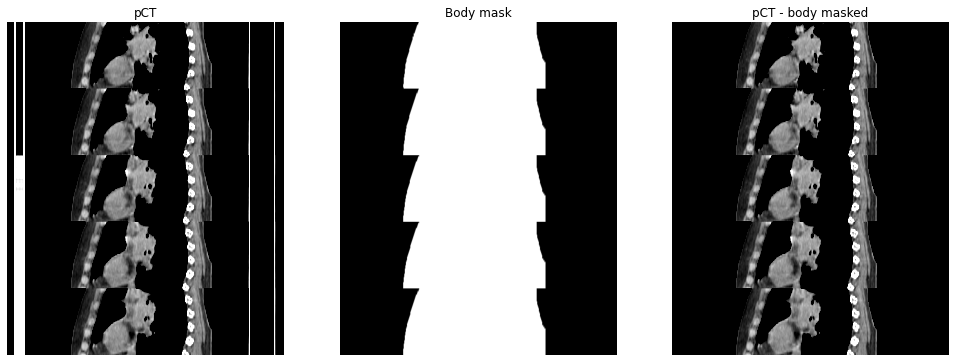

In [23]:
# Visualize
pct_np = pct_np.transpose(2,1,0)
body_mask_np = body_mask_np.transpose(2,1,0)
pct_body_np = pct_body_np.transpose(2,1,0)

visualizer.set_spacing(RESAMPLE_SPACING)
visualizer.multi_image_strips([pct_np, body_mask_np, pct_body_np], 
                              image_types=['CT', 'labelmap', 'CT'], 
                              idx_range=[230, 235], 
                              view='sagittal',
                              subtitles=['pCT', 'Body mask', 'pCT - body masked'])